# Adversarial Search: Playing Connect 4

Student Name: Cameron Ervin

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: CE

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Inital state - The initial state for a game of Connect4 is an empty 6x7 game grid

Actions - Each player can only drop their own pieces in columns 0-7. Each game piece falls to the bottom-most available slot in the board. Players cannot remove game pieces from the board.

Transition model - 

    Result(current current board, drop game piece into board) = Current board + new game piece
    
    Result(board where opponent has 3 in a row, opponent drops winning piece in) = lose game
    
    Result(board where player has 3 in a row, player drops winning piece in) = win game

Goal state - 

    Terminal(no more playable slots) = game over

    Terminal(opponent has 4 in a row) = game over

    Terminal(player has 4 in a row) = game over

    Utility(terminal state) = Utility for a terminal state. Between [-1,1]. -1 if our player loses, 0 if there is a tie, and 1 if our player wins.

How big is the state space? Give an estimate and explain it.

The state space is 6x7 + (6x7)^3 = 74130. This is my estimation for the state space since the size of the board is 6x7 and then each slot can only have a red piece, a yellow piece, or it can be empty. Therefore, we need to add the size of the board and the potential moves.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Space complexity for a minimax search tree is O(bm). b = max branching factor = 7 since there are only 7 possible moves at a given time. m = max depth of tree = 42 since there are 49 slots in the board. O(7*42) = 294.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

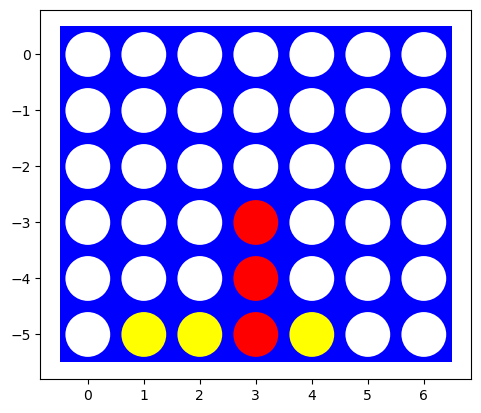

In [2]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
def actions(s):
    action = []
    col_actions = []

    for i in range(len(s[0])):
            if s[0][i] == 0:
                for j in range(len(s)):
                        if s[j][i] == 0:
                                col_actions.append(j)
                action.append((np.max(col_actions),i))
                col_actions = []
    return action

In [4]:
def result(s,player,a):
    r = np.copy(s)
    i,j = a
    r[i][j] = player
    return r

In [5]:
def check_outcome(state, debug = False):

    s = np.copy(state)
    
    # check for winner
    # first check to the right
    for j in range(len(s[0])-3):
        for i in range(len(s)):
            right = s[i][j] + s[i][j+1] + s[i][j+2] + s[i][j+3]
            if debug: print("right = ", right, "for ", (i,j))
            if right == 4 or right == -4:
                return s[i][j]

    # check down
    for j in range(len(s[0])):
            for i in range(len(s)-3):
                down = s[i][j] + s[i+1][j] + s[i+2][j] + s[i+3][j]
                if debug: print("down = ", down, "for ", (i,j))
                if down == 4 or down == -4:
                    return s[i][j]

    # check right diagonal
    for j in range(len(s[0])-3):
            for i in range(len(s)-3):
                right_diag = s[i][j] + s[i+1][j+1] + s[i+2][j+2] + s[i+3][j+3]
                if debug: print("right_diag = ", right_diag, "for ", (i,j))
                if right_diag == 4 or right_diag == -4:
                    return s[i][j]

    # check left diagonal
    for j in range(3,len(s[0])):
            for i in range(len(s)-3):
                left_diag = s[i][j] + s[i+1][j-1] + s[i+2][j-2] + s[i+3][j-3]
                if debug: print("left diag = ", left_diag, "for ", (i,j))
                if left_diag == 4 or left_diag == -4:
                    return s[i][j]

    # check for full board
    top_row = 0
    for i in range(len(s[0])):
        if s[0][i] != 0:
            top_row +=1
    if top_row >= len(s[0]):
        if debug: print('board full')
        return 0
    
    return None

In [6]:
board = [[0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, -1, 0, 1, 0, 0, 1],
        [0, 0, -1, 0, 0, 0, 0],
        [0, 1, 0, -1, 0, 0, 0],
        [1, 0, 0, -1, -1, -1, -1]]
print(check_outcome(board, debug = True))

right =  0 for  (0, 0)
right =  0 for  (1, 0)
right =  0 for  (2, 0)
right =  -1 for  (3, 0)
right =  0 for  (4, 0)
right =  0 for  (5, 0)
right =  0 for  (0, 1)
right =  0 for  (1, 1)
right =  0 for  (2, 1)
right =  -1 for  (3, 1)
right =  0 for  (4, 1)
right =  -2 for  (5, 1)
right =  0 for  (0, 2)
right =  0 for  (1, 2)
right =  1 for  (2, 2)
right =  -1 for  (3, 2)
right =  -1 for  (4, 2)
right =  -3 for  (5, 2)
right =  1 for  (0, 3)
right =  1 for  (1, 3)
right =  2 for  (2, 3)
right =  0 for  (3, 3)
right =  -1 for  (4, 3)
right =  -4 for  (5, 3)
-1


In [7]:
board = [[1, -1, 1, -1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]
print(check_outcome(board, debug = True))

right =  0 for  (0, 0)
right =  0 for  (1, 0)
right =  0 for  (2, 0)
right =  0 for  (3, 0)
right =  0 for  (4, 0)
right =  0 for  (5, 0)
right =  0 for  (0, 1)
right =  0 for  (1, 1)
right =  0 for  (2, 1)
right =  0 for  (3, 1)
right =  0 for  (4, 1)
right =  0 for  (5, 1)
right =  2 for  (0, 2)
right =  0 for  (1, 2)
right =  0 for  (2, 2)
right =  0 for  (3, 2)
right =  0 for  (4, 2)
right =  0 for  (5, 2)
right =  2 for  (0, 3)
right =  0 for  (1, 3)
right =  0 for  (2, 3)
right =  0 for  (3, 3)
right =  0 for  (4, 3)
right =  0 for  (5, 3)
down =  1 for  (0, 0)
down =  0 for  (1, 0)
down =  0 for  (2, 0)
down =  -1 for  (0, 1)
down =  0 for  (1, 1)
down =  0 for  (2, 1)
down =  1 for  (0, 2)
down =  0 for  (1, 2)
down =  0 for  (2, 2)
down =  -1 for  (0, 3)
down =  0 for  (1, 3)
down =  0 for  (2, 3)
down =  1 for  (0, 4)
down =  0 for  (1, 4)
down =  0 for  (2, 4)
down =  1 for  (0, 5)
down =  0 for  (1, 5)
down =  0 for  (2, 5)
down =  1 for  (0, 6)
down =  0 for  (1, 6)
down =

In [8]:
def terminal(s):
    return check_outcome(s) != None

In [9]:
def other(player):
    if player == 1: return -1
    else: return 1

In [10]:
def utility(s,player=1):
    outcome = check_outcome(s)
    if outcome == player:
        return 1
    elif outcome == 0:
        return 0
    elif outcome == other(player):
        return -1
    return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [11]:
def random_player(board,player=1):
    idx = np.random.randint(len(actions(board)))
    return actions(board)[idx]

In [12]:
def switch_player(player, r, y):
    # red = 1, yellow = -1
    if player == 1:
        return -1, y
    else:
        return 1, r

def play(r, y, N = 100, vis = False):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'red': 0, 'yellow': 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 1, r
        
        while True:
            a = fun(board, player)
            board = result(board, player, a)
            
            game_end = terminal(board)   # returns false if the game is not done.
            if game_end:
                outcome = check_outcome(board)
                if outcome == 1:
                    results['red'] += 1
                elif outcome == -1:
                    results['yellow'] += 1
                elif outcome == 0:
                    results['draw'] += 1
                if vis:
                    visualize(board)
                break
            
            player, fun = switch_player(player, r, y)   
    
    return results

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [13]:
# timeit: n ... how many times to execute the statement, 
#         r ... how many times to repeat the timer (default 5)

%time display(play(random_player, random_player, N = 100))

{'red': 68, 'yellow': 32, 'draw': 0}

CPU times: user 461 ms, sys: 26.4 ms, total: 488 ms
Wall time: 211 ms


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [14]:
import math

In [15]:
def alpha_beta_search(board, player = 1):
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):  
    v = utility(state, player)
    if v is not None: return v, None
        
    v, move = -math.inf, None

    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    v = utility(state, player)
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            return v, move
    
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

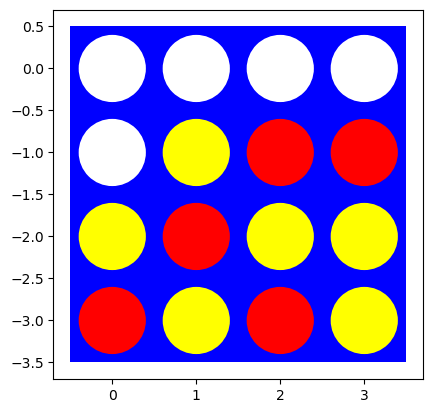

{'move': (0, 3), 'value': 1}

CPU times: user 5.05 ms, sys: 610 µs, total: 5.66 ms
Wall time: 1.79 ms


In [16]:
# board 1
board = [[0, 0, 0, 0],
         [0,-1, 1, 1],
         [-1,1,-1,-1],
         [1,-1, 1,-1]]
visualize(board)
%time display(alpha_beta_search(board))

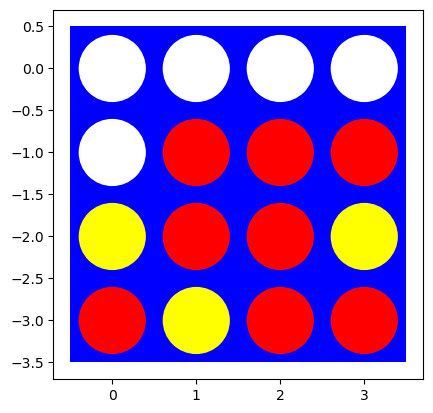

{'move': (1, 0), 'value': 1}

CPU times: user 2.82 ms, sys: 153 µs, total: 2.97 ms
Wall time: 630 µs


In [17]:
# board 2
board = [[0, 0, 0, 0],
         [0, 1, 1, 1],
         [-1,1, 1,-1],
         [1,-1, 1, 1]]
visualize(board)
%time display(alpha_beta_search(board))

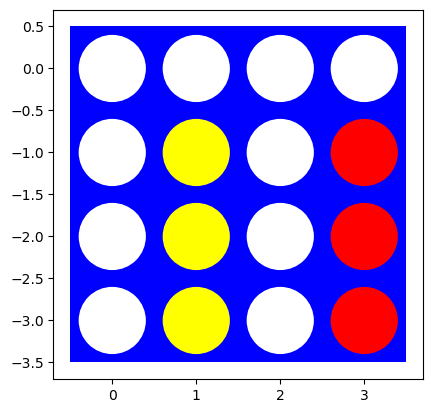

{'move': (0, 3), 'value': 1}

CPU times: user 91.3 ms, sys: 7.68 ms, total: 99 ms
Wall time: 32.1 ms


In [18]:
# board 3
board = [[0, 0, 0, 0],
         [0,-1, 0, 1],
         [0,-1, 0, 1],
         [0,-1, 0, 1]]
visualize(board)
%time display(alpha_beta_search(board))

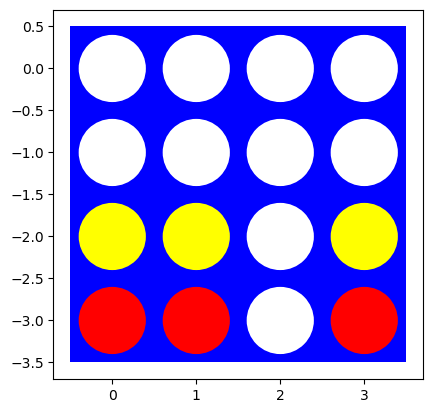

{'move': (3, 2), 'value': 1}

CPU times: user 43.2 ms, sys: 4.68 ms, total: 47.9 ms
Wall time: 14.9 ms


In [19]:
# board 4
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [-1,-1,0,-1],
         [1, 1, 0, 1]]
visualize(board)
%time display(alpha_beta_search(board))

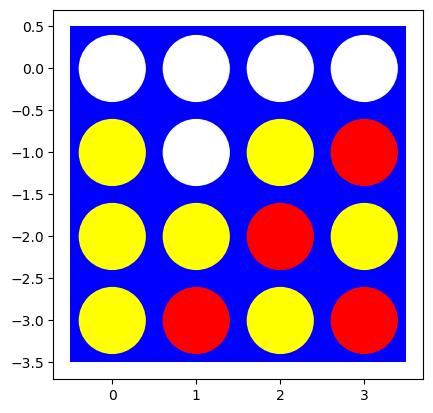

{'move': (0, 0), 'value': -1}

CPU times: user 54 ms, sys: 528 µs, total: 54.5 ms
Wall time: 27.1 ms


In [20]:
# board 5
board = [[0, 0, 0, 0],
         [-1,0,-1, 1],
         [-1,-1,1,-1],
         [-1, 1,-1,1]]
visualize(board)
%time display(alpha_beta_search(board))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

_I will use a board with 4 rows since the alpha beta search with no cutoff takes a while to run._

In [21]:
# 4x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 0), 'value': 0}

CPU times: user 1.13 s, sys: 29.3 ms, total: 1.16 s
Wall time: 838 ms


In [22]:
# 4x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 1), 'value': 0}

CPU times: user 5min, sys: 208 ms, total: 5min 1s
Wall time: 5min 1s


In [23]:
# 4x6 board
board = [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]
#%time display(alpha_beta_search(board))

# I stopped running this cell after 35 minutes. After calculation, this cell should take over 1000 minutes to run. As we can see the time increases durastically with the addition of columns.

_I will stop here since the runtime is so long._

The move time for the 4x4 board was 0.8 seconds. This shot up dramatically for the 4x5 board with a time of 4 minutes 57 seconds. This is a factor of 500 for the increase in time with adding another column. Additionally, this is only for a board with 4 rows, so the runtime would be much longer for a standard size board.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

_We can implement a move ordering algorithm that prioritizes the middle of the board. This assumes that if we move in the middle of the board, there are more chances for pieces to connect on either side._

In [24]:
# priority for 6x7
def actions(s):
    action = []
    col_actions = []
    priority = [0,0.5,1,2,1,0.5,0]

    for i in range(len(s[0])):
            if s[0][i] == 0:
                for j in range(len(s)):
                        if s[j][i] == 0:
                                col_actions.append(j)
                action.append((np.max(col_actions),i))
                col_actions = []

    priority_action = [a for _,a in sorted(zip(priority,action), reverse = True)]
    return priority_action

In [25]:
# priority for any size
def actions(s):
    action = []
    col_actions = []
    priority = []
    length = len(s[0])

    if length%2 == 0:
        p = 0
        for i in range(0,int(length/2)):
            if s[0][i] == 0:
                priority.append(p)
                p += 1
        for i in range(int(length/2), length):
            if s[0][i] == 0:
                p -= 1
                priority.append(p)
    else:
        p = -1
        for i in range(0,math.ceil(length/2)):
            if s[0][i] == 0:
                p += 1
                priority.append(p)
        for i in range(math.ceil(length/2), length):
            if s[0][i] == 0:
                p -= 1
                priority.append(p)
        
    for i in range(len(s[0])):
            if s[0][i] == 0:
                for j in range(len(s)):
                        if s[j][i] == 0:
                                col_actions.append(j)
                action.append((np.max(col_actions),i))
                col_actions = []

    priority_action = [a for _,a in sorted(zip(priority,action), reverse = True)]
    return priority_action

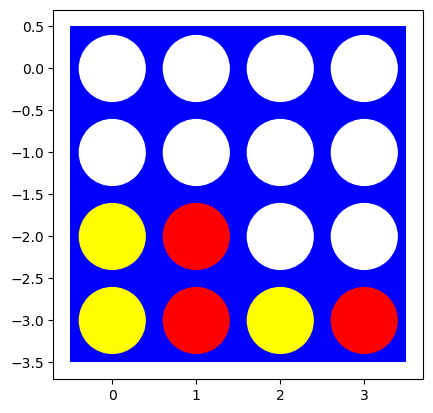

[(2, 2), (1, 1), (2, 3), (1, 0)]

In [26]:
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [-1,1, 0, 0],
         [-1,1,-1, 1]]
visualize(board)
actions(board)

In [27]:
# 4x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 2), 'value': 0}

CPU times: user 4.15 s, sys: 15.8 ms, total: 4.17 s
Wall time: 3.84 s


In [28]:
# 4x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 2), 'value': 0}

CPU times: user 2min 47s, sys: 102 ms, total: 2min 48s
Wall time: 2min 48s


In [29]:
import pandas as pd
dict = {'Algorithm & Size' : ['No Move Ordering, 4x4','No Move Ordering, 4x5','Move Ordering, 4x4','Move Ordering, 4x5'], 
        'Runtime' : ['0.812 s', '4m 57s', '3.68 s', '2m 42s']}
df = pd.DataFrame(dict)
display(df)

,Algorithm & Size,Runtime
0,"No Move Ordering, 4x4",0.812 s
1,"No Move Ordering, 4x5",4m 57s
2,"Move Ordering, 4x4",3.68 s
3,"Move Ordering, 4x5",2m 42s


It appears the runtime for the 4x4 board goes up when adding move ordering. However, the runtime for the 4x5 board goes down. This could be because of a number of different factors. Possibly, prioritizing the center of the board is better for both larger board or boards with an odd number of columns.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [30]:
# 6x7 board
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

#%time display(alpha_beta_search(board))

# runtime is very high

_Let's add an opening series for the agent to reduce the runtime for the opening move on an empty board._

In [31]:
def opening(state,player=1,debug=False):
    # use convolution and alpha beta search to open
    s = np.copy(state)
    length = len(s[0])
    opening_col = []

    if length%2 == 0:
        for i in range(int(length/2)-2,int(length/2)+2):
            opening_col.append(i)
    elif length%2 != 0:
        for i in range(math.ceil(length/2)-2,math.ceil(length/2)+1):
            opening_col.append(i)

    search_area = []

    for row in range(len(s)-3,len(s)):
        conv_row = []
        for col in opening_col:
            conv_row.append(s[row][col])
        search_area.append(conv_row)
    if debug: print('search area: ',search_area)

    a, v = list(alpha_beta_search(search_area, player=1).values())
    if debug: print('result from alpha beta: ',a)
    idx = a[1]
    #if debug: print('search_area[2]: ', search_area[2], 'a[1]: ', a[1])
    col = opening_col[a[1]]

    #col = np.random.choice(search_area)
    if debug: print('correlating column of original board: ',col)

    action = []
    for row in range(len(s)):
        if s[row][col] == 0:
            action.append(row)

    if debug: print('returning action: ', (np.max(action),col))
    return (np.max(action),col), v


In [32]:
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 2, 3, 0, 0]]

opening(board, debug=True)

search area:  [[0, 0, 0], [0, 0, 0], [1, 2, 3]]
result from alpha beta:  (1, 1)
correlating column of original board:  3
returning action:  (4, 3)


((4, 3), 0)

In [33]:
# alpha beta search with opening moves
def alpha_beta_search_opening(board, player = 1):
    b = np.copy(board)
    if np.count_nonzero(b) < 4:
        a, v = opening(board,player)
        # keep same signature as regular return
        return {"move": a, "value": v}
                
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    return {"move": move, "value": value}

In [34]:
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]
alpha_beta_search_opening(board)

{'move': (3, 2), 'value': 0}

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

_Redefining the play function to change board size_

In [35]:
def play_four(r, y, N = 100, vis = False):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'red': 0, 'yellow': 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board(shape=(4,4))
        player, fun = 1, r
        
        while True:
            a = fun(board, player)
            #print('action: ',a)
            board = result(board, player, a)
            
            game_end = terminal(board)   # returns false if the game is not done.
            if game_end:
                outcome = check_outcome(board)
                if outcome == 1:
                    results['red'] += 1
                elif outcome == -1:
                    results['yellow'] += 1
                elif outcome == 0:
                    results['draw'] += 1
                if vis:
                    visualize(board)
                break
            
            player, fun = switch_player(player, r, y)   
    
    return results

In [36]:
def ab_player(board,player=1):
    return list(alpha_beta_search_opening(board,player).values())[0]

In [37]:
# opening agent
%time display(play_four(ab_player, random_player, N = 100))

{'red': 47, 'yellow': 0, 'draw': 53}

CPU times: user 23.3 s, sys: 19.8 ms, total: 23.3 s
Wall time: 23.4 s


_Performance is about the same, so we will move forward with the opening agent since it is faster._

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [38]:
def eval_adjacent(adjacent,player):
    p_pieces = 0
    op_pieces = 0
    spaces = 0
    score = 0

    for p in adjacent:
        if p == player:
            p_pieces += 1
        elif p == -player:
            op_pieces += 1
        else:
            spaces += 1

    if p_pieces == 2 and spaces == 2:
        score = 0.05
    elif p_pieces == 2:
        score = 0.025
    elif p_pieces == 3 or op_pieces == 3:
        score = 0.1
    elif p_pieces == 1:
        score = 0.025

    return score
    

In [39]:
def eval_fun(state, player = 1):
    # first check if terminal
    s = state.copy()

    if utility(state, player) != None: return utility(state,player), True
    score = 0

    # check heuristic to the right
    for j in range(len(s[0])-3):
        for i in range(len(s)):
            right = [s[i][j], s[i][j+1], s[i][j+2], s[i][j+3]]
            score += eval_adjacent(right, player)
    
    # check heuristic down
    for j in range(len(s[0])):
        for i in range(len(s)-3):
            down = [s[i][j], s[i+1][j], s[i+2][j], s[i+3][j]]
            score += eval_adjacent(down, player)

    # check heuristic along right diagonal
    for j in range(len(s[0])-3):
        for i in range(len(s)-3):
            right_diag = [s[i][j], s[i+1][j+1], s[i+2][j+2], s[i+3][j+3]]
            score += eval_adjacent(right_diag, player)

    # check heuristic along left diagonal
    for j in range(3,len(s[0])):
        for i in range(len(s)-3):
            left_diag = [s[i][j], s[i+1][j-1], s[i+2][j-2], s[i+3][j-3]]
            score += eval_adjacent(left_diag, player)

    return score, False

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [40]:
def alpha_beta_search_cutoff(board, cutoff = None, player = 1):
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    return {"move" : move, "value" : value}

def max_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    v, game_end = eval_fun(state, player)
    if((cutoff != None and depth >= cutoff) or game_end):
        if game_end:
            alpha, beta = v, v
        return v, None
    
    v, move = -math.inf, None

    for a in actions(state):
        v2, a2 = min_value_ab_cutoff(result(state, player, a), player, alpha, beta, depth+1, cutoff)
        if v2 >v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v>= beta: return v, move

    return v, move

def min_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    v, game_end = eval_fun(state, player)
    if((cutoff != None and depth >= cutoff) or game_end):
        if game_end:
            alpha, beta = v, v
        return v, None
    
    v, move = +math.inf, None

    for a in actions(state):
        v2, a2 = max_value_ab_cutoff(result(state, other(player), a), player, alpha, beta, depth+1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move

    return v, move

In [41]:
# alpha beta search with opening moves
def alpha_beta_search_cutoff_opening(board, cutoff = None, player = 1):
    b = np.copy(board)
    if np.count_nonzero(b) < 6:
        a, v = opening(board,player)
        # keep same signature as regular return
        return {"move": a, "value": v}
                
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    return {"move": move, "value": value}

In [42]:
# 6x7 board
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff_opening(board, cutoff=20))

{'move': (5, 3), 'value': 0}

CPU times: user 3.36 ms, sys: 1.31 ms, total: 4.67 ms
Wall time: 3.73 ms


_Runtime for the first couple of moves is the same regardless of cutoff because of the opening move component of the algorithm. Let's see how it performs for boards that are not empty._

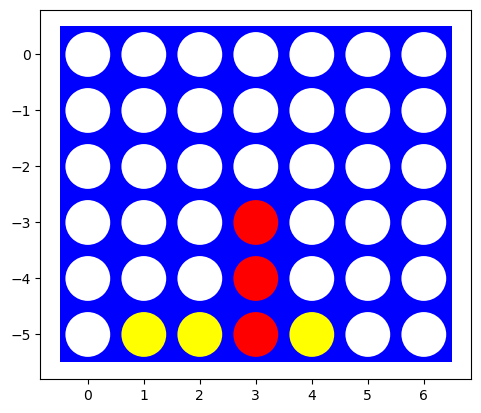

{'move': (4, 4), 'value': 1.624999999999999}

CPU times: user 2.22 s, sys: 62.4 ms, total: 2.28 s
Wall time: 1.79 s


In [43]:
# cutoff = 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

In [44]:
# cutoff = 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff(board, cutoff=5))

{'move': (5, 3), 'value': 0.6750000000000003}

CPU times: user 60.4 ms, sys: 4.96 ms, total: 65.4 ms
Wall time: 61.1 ms


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

_Let's use the same board from earlier to see how our new algorithms performs compared to the older algorithms._

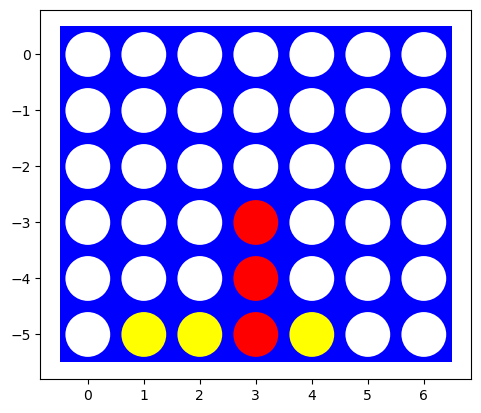

{'move': (4, 4), 'value': 1.624999999999999}

CPU times: user 2.19 s, sys: 2.55 ms, total: 2.19 s
Wall time: 1.78 s


In [45]:
# board 1
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

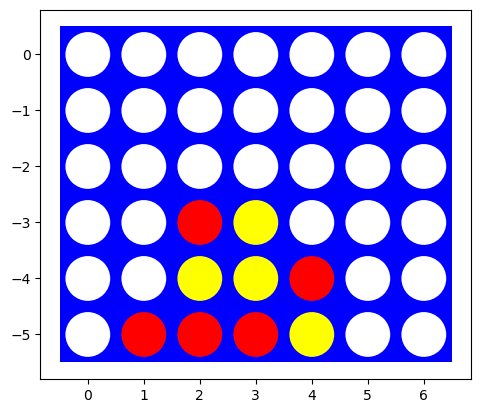

{'move': (2, 2), 'value': 1.7499999999999991}

CPU times: user 4.59 s, sys: 129 ms, total: 4.72 s
Wall time: 4.25 s


In [46]:
# board 2
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1,-1, 0, 0, 0],
         [0, 0,-1,-1, 1, 0, 0],
         [0, 1, 1, 1,-1, 0, 0]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

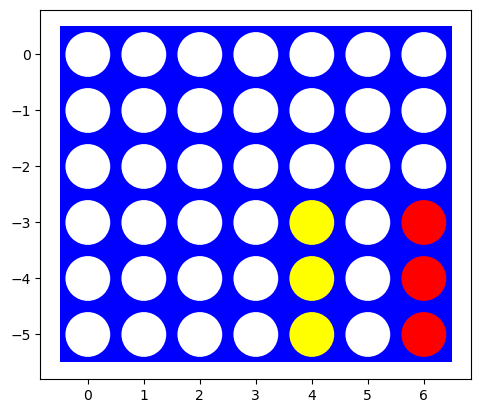

{'move': (2, 4), 'value': 1.2249999999999994}

CPU times: user 2.34 s, sys: 62 ms, total: 2.41 s
Wall time: 1.9 s


In [47]:
# board 3
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0,-1, 0, 1],
         [0, 0, 0, 0,-1, 0, 1],
         [0, 0, 0, 0,-1, 0, 1]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

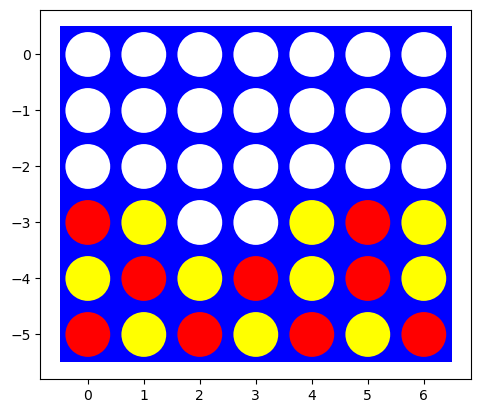

{'move': (3, 3), 'value': -1}

CPU times: user 2.95 s, sys: 88.6 ms, total: 3.04 s
Wall time: 2.51 s


In [48]:
# board 4
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [1,-1, 0, 0,-1, 1,-1],
         [-1,1,-1, 1,-1, 1,-1],
         [1,-1, 1,-1, 1,-1, 1]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

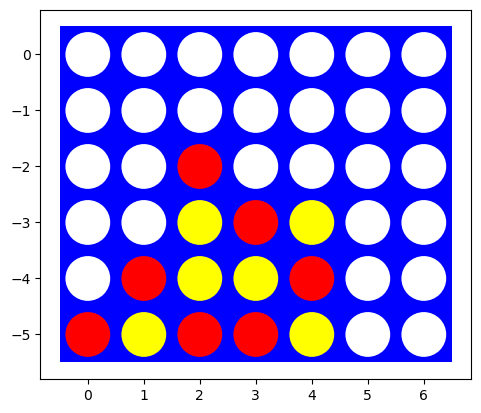

{'move': (2, 3), 'value': 2.3249999999999984}

CPU times: user 6.71 s, sys: 204 ms, total: 6.91 s
Wall time: 6.29 s


In [49]:
# board 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0,-1, 1,-1, 0, 0],
         [0, 1,-1,-1, 1, 0, 0],
         [1,-1, 1, 1,-1, 0, 0]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=10))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [50]:
# 6x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff_opening(board, cutoff=10))

{'move': (5, 2), 'value': 0}

CPU times: user 73.9 ms, sys: 9.38 ms, total: 83.3 ms
Wall time: 76.4 ms


In [51]:
# 6x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff_opening(board, cutoff=10))

{'move': (5, 2), 'value': 0}

CPU times: user 3.75 ms, sys: 1.9 ms, total: 5.64 ms
Wall time: 4.42 ms


In [52]:
# 6x6 board
board = [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff_opening(board, cutoff=10))

{'move': (5, 3), 'value': 0}

CPU times: user 72.6 ms, sys: 1.37 ms, total: 74 ms
Wall time: 80.6 ms


In [53]:
# 6x7 board
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff_opening(board, cutoff=10))

{'move': (5, 3), 'value': 0}

CPU times: user 3.38 ms, sys: 1.42 ms, total: 4.8 ms
Wall time: 3.83 ms


With the opening component of the algorithm, plus the cutoff depth, it takes almost no time at all to create the first move. 

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [54]:
def abc_player(board,player=1):
    return list(alpha_beta_search_cutoff_opening(board, cutoff=8).values())[0]

In [55]:
%time display(play(abc_player, abc_player, N = 1))

{'red': 1, 'yellow': 0, 'draw': 0}

CPU times: user 28 s, sys: 90.3 ms, total: 28.1 s
Wall time: 28 s


## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [56]:
def playout(state, action, player = 1):
    state = result(state, player, action)
    current_player = other(player)
    
    while(True):
        u = utility(state, player)
        if u != None: return(u)
        
        idx = np.random.randint(len(actions(board)))
        a = actions(board)[idx]
        state = result(state, current_player, a)
        
        current_player = other(current_player)

In [57]:
def playouts(board, action, player = 1, N = 100):
    """Perform N playouts following the given action for the given board."""
    return [ playout(board, action, player) for i in range(N) ]

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

u = playouts(board, (5,3))
print("Playout results:", u)

print(f"mean utility: {np.mean(u)}")

p_win = sum(np.array(u) == +1)/len(u)
p_loss = sum(np.array(u) == -1)/len(u)
p_draw = sum(np.array(u) == 0)/len(u)
print(f"win probability: {p_win}")
print(f"loss probability: {p_loss}")
print(f"draw probability: {p_draw}")

Playout results: [-1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1]
mean utility: 0.14
win probability: 0.57
loss probability: 0.43
draw probability: 0.0


In [58]:
def pmcs(board, N=100, player=1):
    acts = actions(board)
    n = math.floor(N/len(acts))
    ps = { i : np.mean(playouts(board, i, player, N = n)) for i in acts }

    action = max(ps, key=ps.get)
    return action

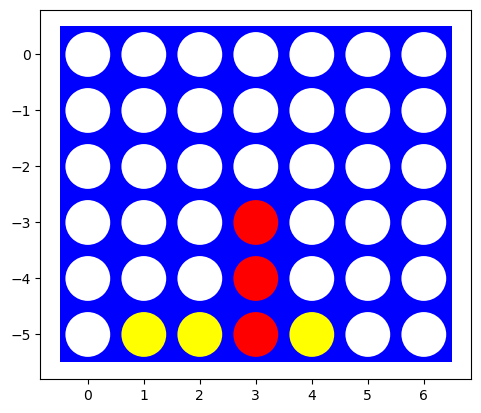

(2, 3)
CPU times: user 8.35 s, sys: 77.2 ms, total: 8.43 s
Wall time: 7.95 s


In [59]:
# board 1
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)
%time print(pmcs(board, N = 10000))

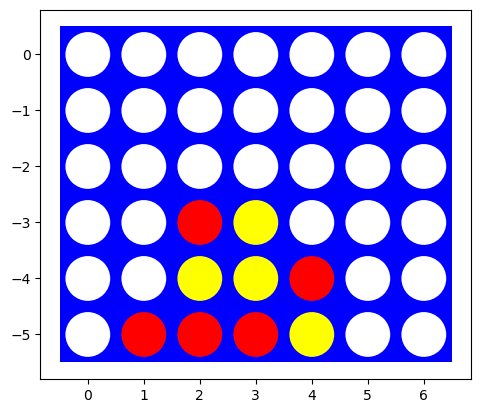

(2, 3)
CPU times: user 10.1 s, sys: 322 ms, total: 10.4 s
Wall time: 9.69 s


In [60]:
# board 2
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1,-1, 0, 0, 0],
         [0, 0,-1,-1, 1, 0, 0],
         [0, 1, 1, 1,-1, 0, 0]]
visualize(board)
%time print(pmcs(board, N = 10000))

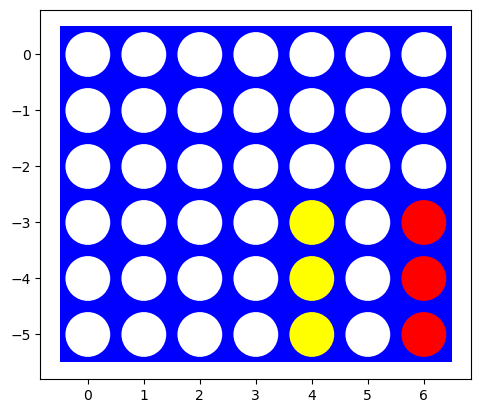

(2, 6)
CPU times: user 4.95 s, sys: 172 ms, total: 5.12 s
Wall time: 4.57 s


In [61]:
# board 3
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0,-1, 0, 1],
         [0, 0, 0, 0,-1, 0, 1],
         [0, 0, 0, 0,-1, 0, 1]]
visualize(board)
%time print(pmcs(board, N = 10000))

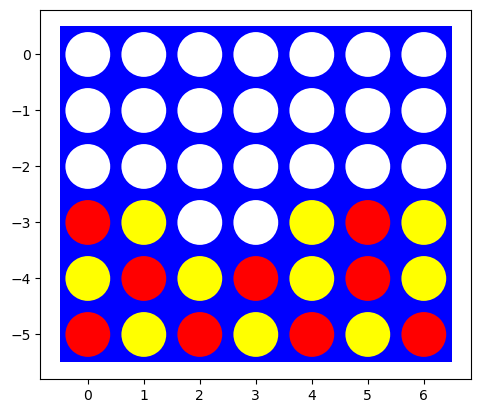

(3, 2)
CPU times: user 5.98 s, sys: 210 ms, total: 6.19 s
Wall time: 5.59 s


In [62]:
# board 4
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [1,-1, 0, 0,-1, 1,-1],
         [-1,1,-1, 1,-1, 1,-1],
         [1,-1, 1,-1, 1,-1, 1]]
visualize(board)
%time print(pmcs(board, N = 10000))

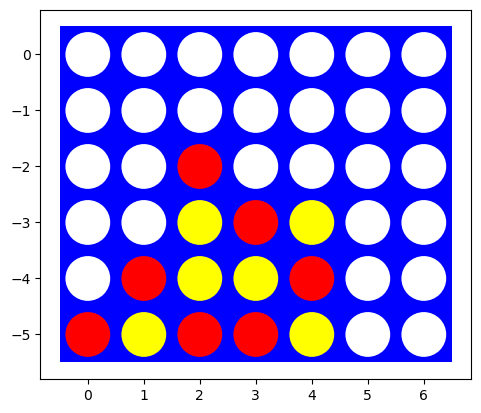

(2, 3)
CPU times: user 10.5 s, sys: 361 ms, total: 10.8 s
Wall time: 10 s


In [63]:
# board 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0,-1, 1,-1, 0, 0],
         [0, 1,-1,-1, 1, 0, 0],
         [1,-1, 1, 1,-1, 0, 0]]
visualize(board)
%time print(pmcs(board, N = 10000))

### Best First Move

Use Pure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [64]:
print("10000 playouts give a better utility estimate.")
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]
%time print(pmcs(board, N = 10000))

10000 playouts give a better utility estimate.
(5, 3)
CPU times: user 18.9 s, sys: 500 ms, total: 19.4 s
Wall time: 19 s


Pure Monte Carlo search determines that (5,3) is the best first move. This makes sense given there would be the most opportunities to connect pieces to (5,3) as it is in the middle